In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [3]:
# define problem
problem = GMM(negate=True).to(**tkwargs)

In [4]:
def plot_objective(problem, num_samples: int = 200):
    num_dim = problem.bounds.shape[-1]
    num_obj = problem.ref_point.shape[-1]

    fig = plt.figure(figsize=(5 * (num_dim + 1), 5))

    # only plot the first two dimensions
    xx, yy = np.meshgrid(
        np.linspace(
            *problem.bounds.t()[0], num_samples
        ),
        np.linspace(
            *problem.bounds.t()[1], num_samples
        ),
    )
    input_data = np.vstack((xx.flatten(), yy.flatten())).T
    input_data = torch.from_numpy(input_data)
    z = problem(input_data)
    pareto = is_non_dominated(z)
    pareto_set= z.numpy().copy()
    pareto_set[~pareto] = np.nan

    for i in range(num_dim):
        ax = plt.subplot2grid((1, num_dim + 1), (0, i))
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')

        # plot functions
        countourset = ax.contourf(
            xx,
            yy,
            z[:, i].reshape(xx.shape),
        )

        # plot pareto set mask
        ax.scatter(*input_data[pareto].t(), color='tab:red', s=10, label='pareto set')

        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f"objective {i+1}")
        ax.legend()
        clb.ax.set_title('z')

    ax_pareto = plt.subplot2grid((1, num_dim + 1), (0, num_dim))
    idx = np.argsort(pareto_set[:, 0])
    ax_pareto.plot(*pareto_set[idx].T, color='tab:red', label='approximated pareto front')
    ax_pareto.scatter(*pareto_set[idx].T, color='tab:red', s=10)
    ax_pareto.scatter(*problem.ref_point.t(), color='tab:red', marker='x', label='refence point')
    ax_pareto.set_title("pareto front")
    ax_pareto.legend()
    plt.tight_layout()

## Problem

The approximated pareto set and pareto front is shown in the following figure.

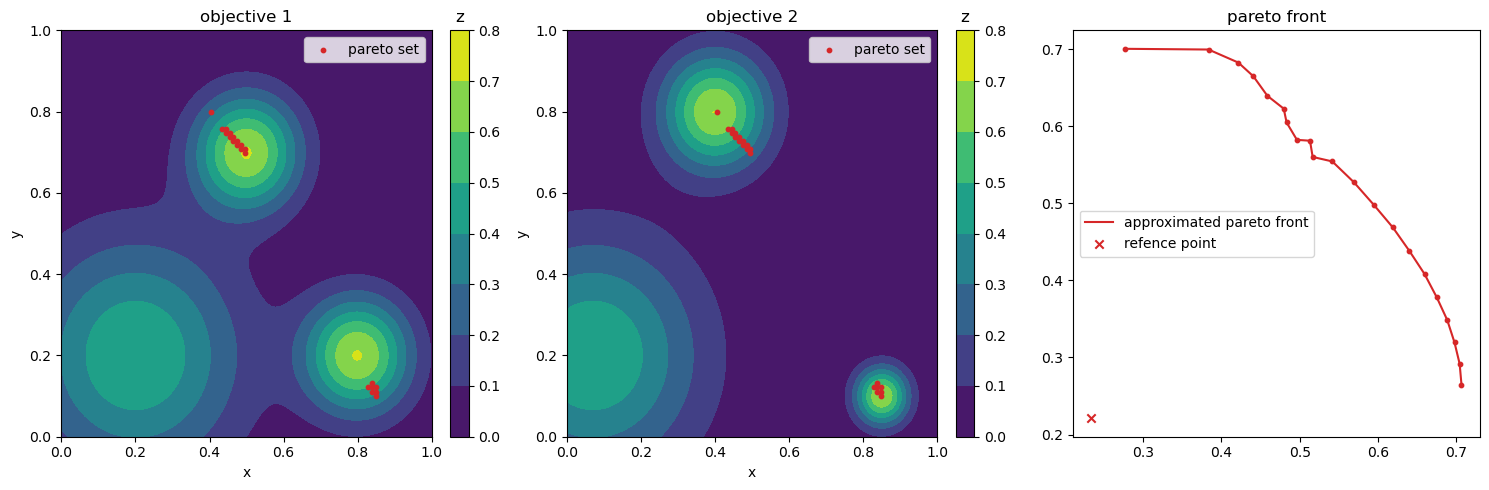

In [5]:
plot_objective(problem, num_samples=100)

In [6]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

# def generate_initial_data(problem, n=6):
#     X_obs = torch.empty(0, problem.bounds.shape[-1])
#     y_obs = torch.empty(0, problem.bounds.shape[-1])
#     while len(X_obs) < n:
#         x = draw_sobol_samples(bounds=problem.bounds, n=1, q=1).squeeze(1)
#         y = problem(x)
#         if (y > problem.ref_point).all(dim=-1).item():
#             X_obs = torch.concat([X_obs, x], dim=0)
#             y_obs = torch.concat([y_obs, y], dim=0)

#     return X_obs, y_obs

In [7]:
init_x, init_y = generate_initial_data(problem, n=50)

## Pareto dominance

**For Maximization**: an objective vector $\mathbf f(\mathbf x)$ Pareto-dominates $\mathbf f (\mathbf x′)$, denoted as $\mathbf f(\mathbf x) \succ \mathbf f(\mathbf x')$, if $f^{(m)}(x) \geq f^{(m)}(x′)$ for all $m = 1, \dots, M$ and there exists at least one $m \in \{1, . . . , M\}$ such that $f^{(m)}(x) > f^{(m)}(x′)$.

## Modeling the objective space

A classifier answers a question that whether the objective value $y$ outperform a certain fraction of point: $\hat \pi(\mathbf x) = p(y \geq \tau \mid \mathbf x)$.

We try to model the separately model the objectives via BORE (PI). For a bi-objective case we have: $$\hat \pi^1 (\mathbf x) = p(y^1 \geq \tau^1 \mid \mathbf x)$$ $$ \hat \pi^2 (\mathbf x) = p(y^2 \geq \tau^2 \mid \mathbf x)\,.$$
Assuming the objectives are independent: $$ p(y^1 \geq \tau^1, y^2 \geq \tau^2 \mid \mathbf x) = p(y^1 \geq \tau^1 \mid \mathbf x) \cdot p(y^1 \geq \tau^1 \mid \mathbf x)\,. $$
In this case, this convert to determine whether $\mathbf f(\mathbf x)$ weakly dominate a point $(\tau^1, \tau^2)$: $p(\mathbf f(\mathbf x) \succeq \bm \tau)$.

If we jointly model **BORE** with $\gamma$, we can dynamically vary the threshold $(\tau^m)^M_{m=1}$, which allowing us:
- Output the likelihood for different $\bm \tau$
- We can map the current observation to $\bm \tau$: $\bm \tau = \mathbf f(\mathbf x_i)$, and output likelihood that a given $\mathbf x$ outperforming an specific observation $\mathbf x_i$.

## Generate data

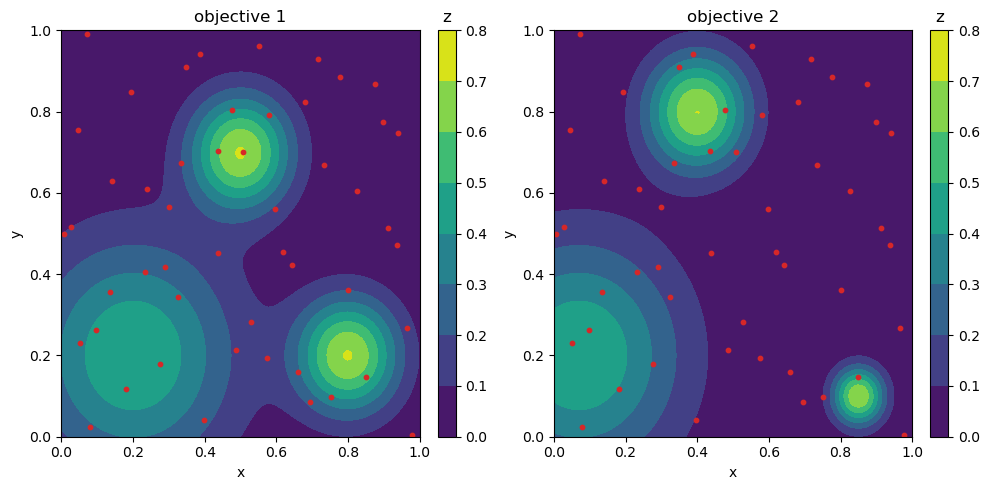

In [8]:
num_dim = problem.bounds.shape[-1]
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.t()[0], 100
    ),
    np.linspace(
        *problem.bounds.t()[1], 100
    ),
)
input_data = np.vstack((xx.flatten(), yy.flatten())).T
input_data = torch.from_numpy(input_data)
z = problem(input_data)

fig = plt.figure(figsize=(5 * (num_dim), 5))
for i in range(num_dim):
    ax = plt.subplot2grid((1, num_dim), (0, i))
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        z[:, i].reshape(xx.shape),
    )

    # plot observations
    ax.scatter(*init_x.t(), s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"objective {i+1}")
    clb.ax.set_title('z')
plt.tight_layout()

In [9]:
from optimizers.lfbo.lfbo_joint_rand import LFBO_JointRand

optimizer_obj_1 = LFBO_JointRand(input_dim=problem.bounds.shape[-1], output_dim=1, weight_type='pi')
optimizer_obj_1.fit(init_x, -init_y[:, :1], S=5000)

optimizer_obj_2 = LFBO_JointRand(input_dim=problem.bounds.shape[-1], output_dim=1, weight_type='pi')
optimizer_obj_2.fit(init_x, -init_y[:, -1:], S=5000)

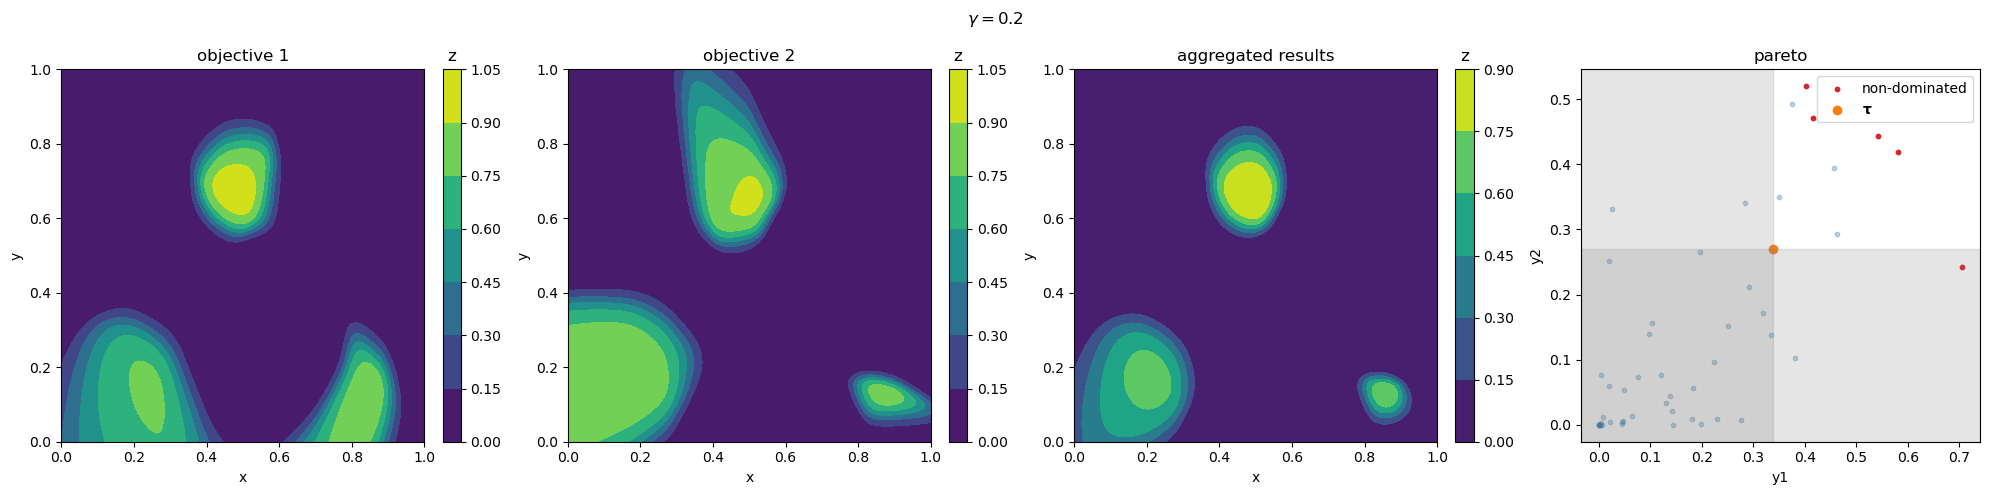

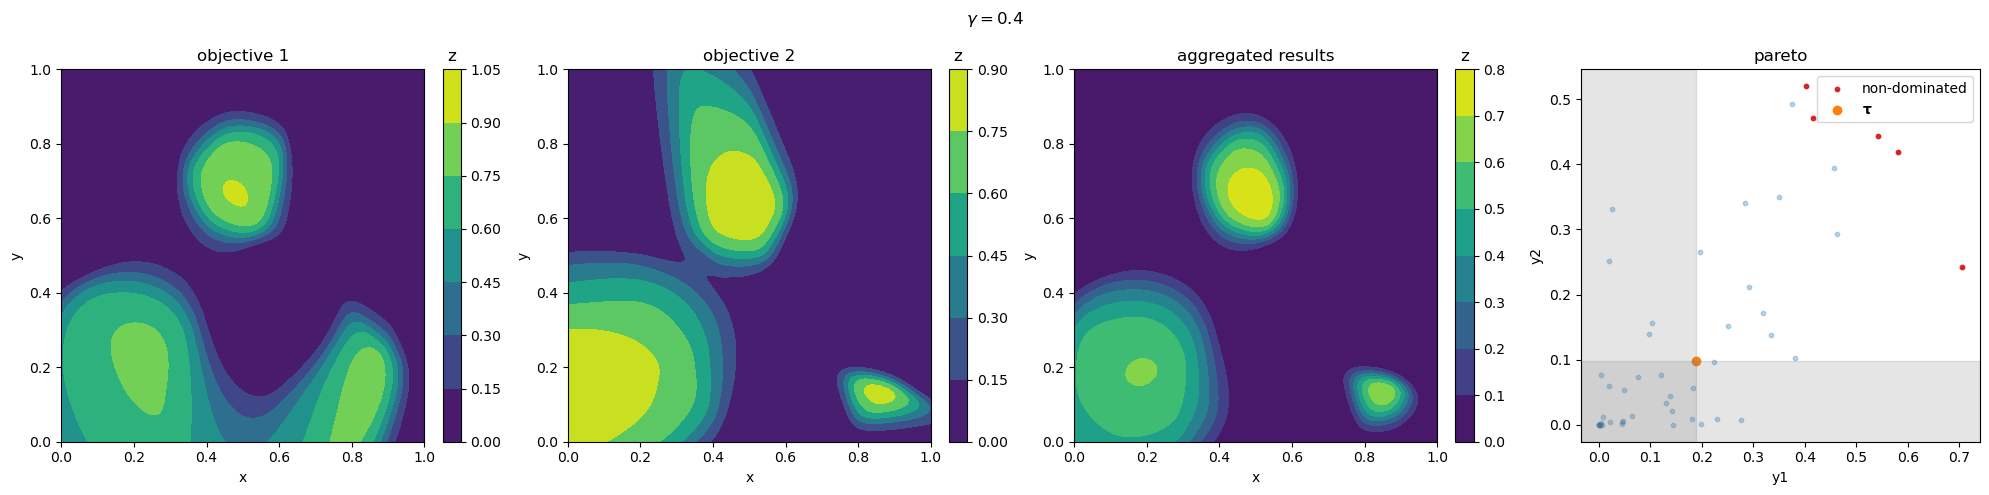

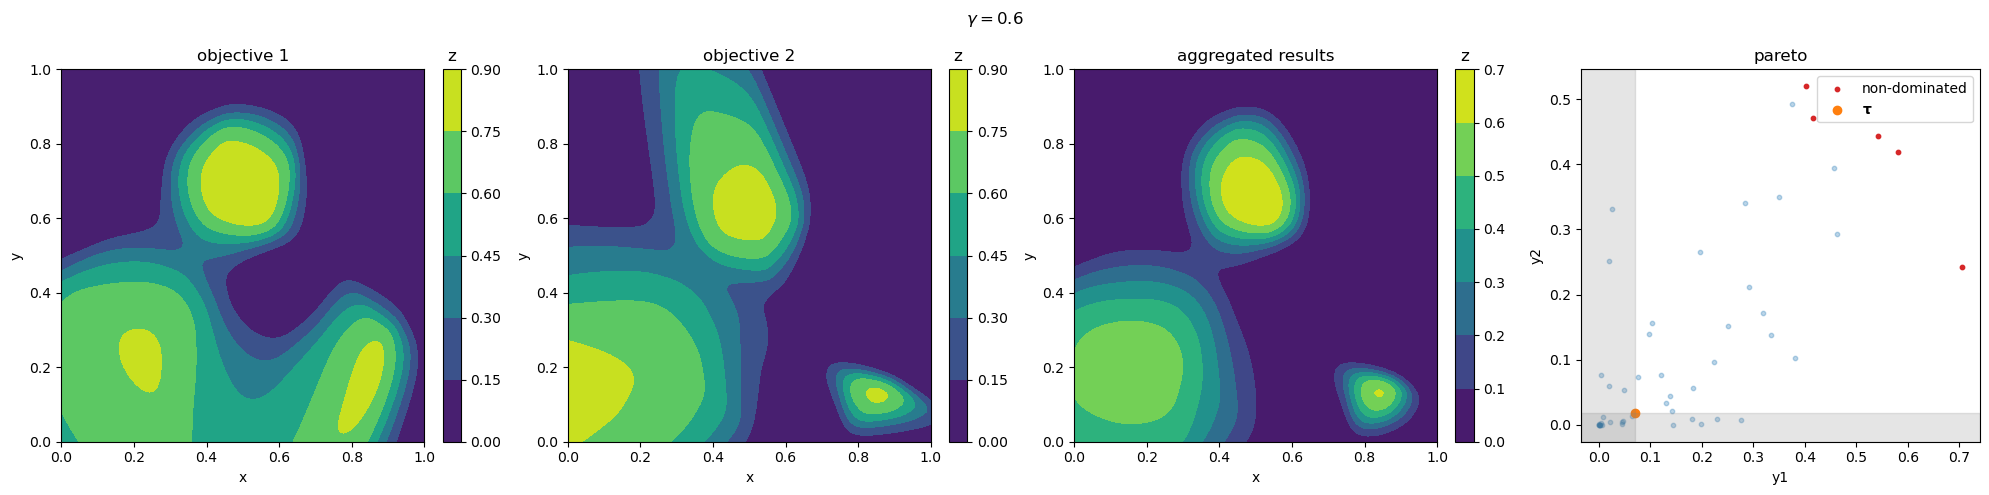

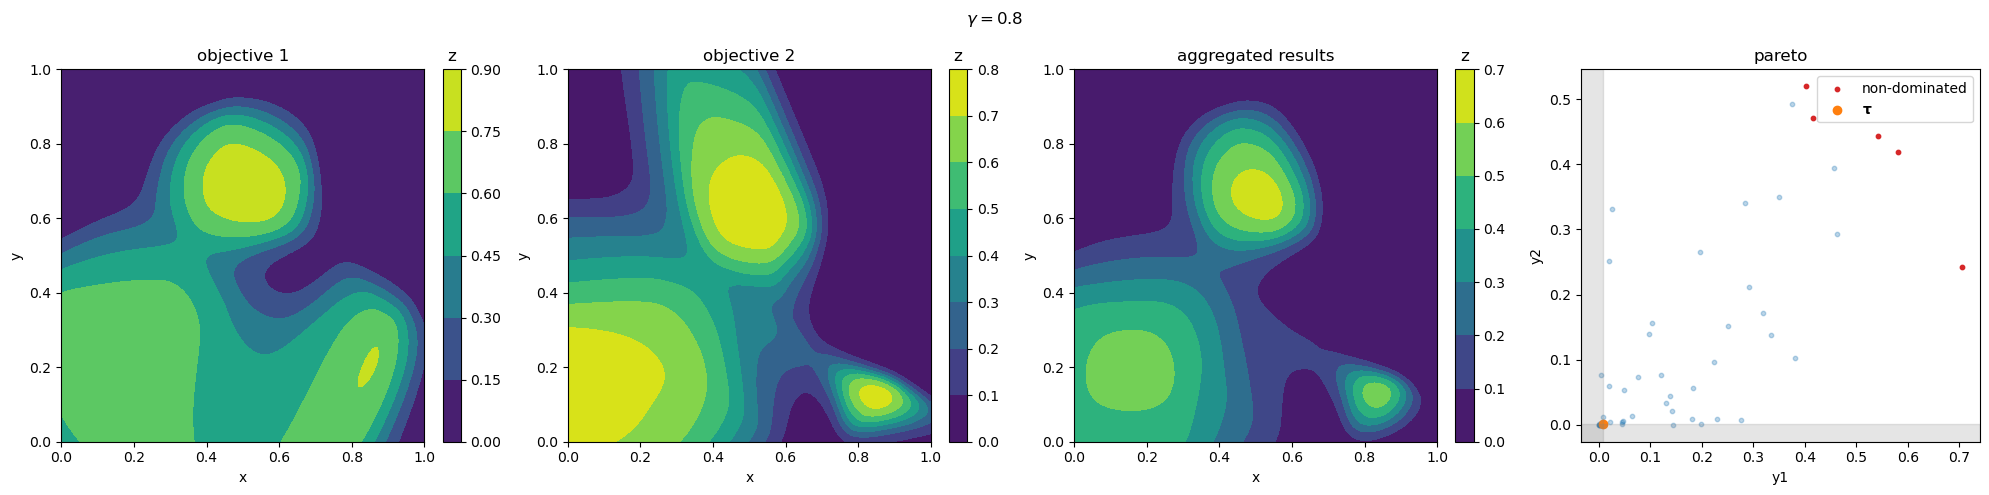

In [10]:
for gamma in [0.2, 0.4, 0.6, 0.8]:
    fig = plt.figure(figsize=(5 * (num_dim + 2), 5))
    for i, optimizer in enumerate([optimizer_obj_1, optimizer_obj_2]):
        ax = plt.subplot2grid((1, num_dim + 2), (0, i))
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')

        preds = optimizer.predict(input_data, gamma=gamma)
        # plot functions
        countourset = ax.contourf(
            xx,
            yy,
            preds.reshape(xx.shape),
        )

        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f"objective {i+1}")
        clb.ax.set_title('z')

    # plot aggregated results
    ax_agg = plt.subplot2grid((1, num_dim + 2), (0, 2))
    div = make_axes_locatable(ax_agg)
    cax = div.append_axes('right', '5%', '5%')
    preds_1 = optimizer_obj_1.predict(input_data, gamma=gamma)
    preds_2 = optimizer_obj_2.predict(input_data, gamma=gamma)
    preds = preds_1 * preds_2
    countourset = ax_agg.contourf(
        xx,
        yy,
        preds.reshape(xx.shape),
    )
    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax_agg.set_xlabel('x')
    ax_agg.set_ylabel('y')
    ax_agg.set_title(f"aggregated results")
    clb.ax.set_title('z')

    # plot pareto results
    ax_pareto = plt.subplot2grid((1, num_dim + 2), (0, 3))
    pareto = is_non_dominated(init_y)
    ax_pareto.scatter(*init_y[~pareto].t(), s=10, alpha=0.3)
    ax_pareto.scatter(*init_y[pareto].t(), s=10, color='tab:red', label="non-dominated")

    tau_1 = -torch.quantile(-torch.unique(init_y[:, 0]), q=gamma)
    tau_2 = -torch.quantile(-torch.unique(init_y[:, 1]), q=gamma)
    ax_pareto.scatter(tau_1, tau_2, label=r"$\mathbf{\tau}$")
    x_lim = ax_pareto.get_xlim()
    y_lim = ax_pareto.get_ylim()
    ax_pareto.axhspan(y_lim[0], tau_2, alpha=0.2, color='tab:gray')
    ax_pareto.axvspan(x_lim[0], tau_1, alpha=0.2, color='tab:gray')
    ax_pareto.set_xlim(*x_lim)
    ax_pareto.set_ylim(*y_lim)

    ax_pareto.set_xlabel('y1')
    ax_pareto.set_ylabel('y2')
    ax_pareto.set_title('pareto')
    ax_pareto.legend()
    
    fig.suptitle(rf"$\gamma={gamma}$")
    plt.tight_layout()
    plt.show()

## MBORE

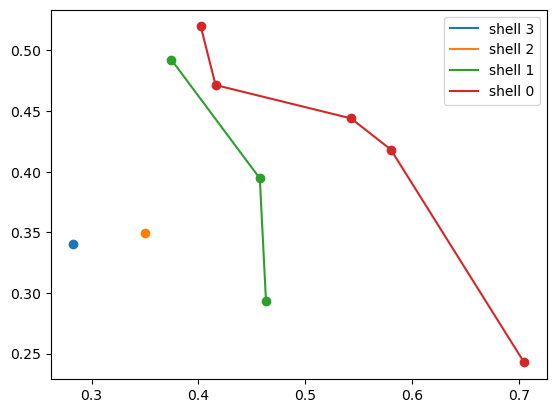

In [11]:
import pygmo as pg

better_than_ref = torch.all(init_y > problem.ref_point, dim=1)
y = -init_y[better_than_ref].numpy()
ndf, _, _, _ = pg.fast_non_dominated_sorting(y)
hvc = np.zeros((y.shape[0],))

for shell_idx in range(len(ndf) - 1, -1, -1):
    shell = ndf[shell_idx]

    plt.scatter(*-y[shell].T)
    sort_idx = np.argsort(y[shell][:, 0])
    plt.plot(*-y[shell][sort_idx].T, label=f"shell {shell_idx}")
    plt.legend()

    hv_class = pg.core.hypervolume(y[shell])
    hvc[shell] += hv_class.contributions(-problem.ref_point)
    if shell_idx > 0:
        hvc[ndf[shell_idx - 1]] += np.max(hvc[shell])

rank = np.argsort(hvc)

gamma = 0.2: 3.8513861315526743
gamma = 0.4: 3.5904940700540107
gamma = 0.6: 3.242577337146291
gamma = 0.8: 2.1137787284149456


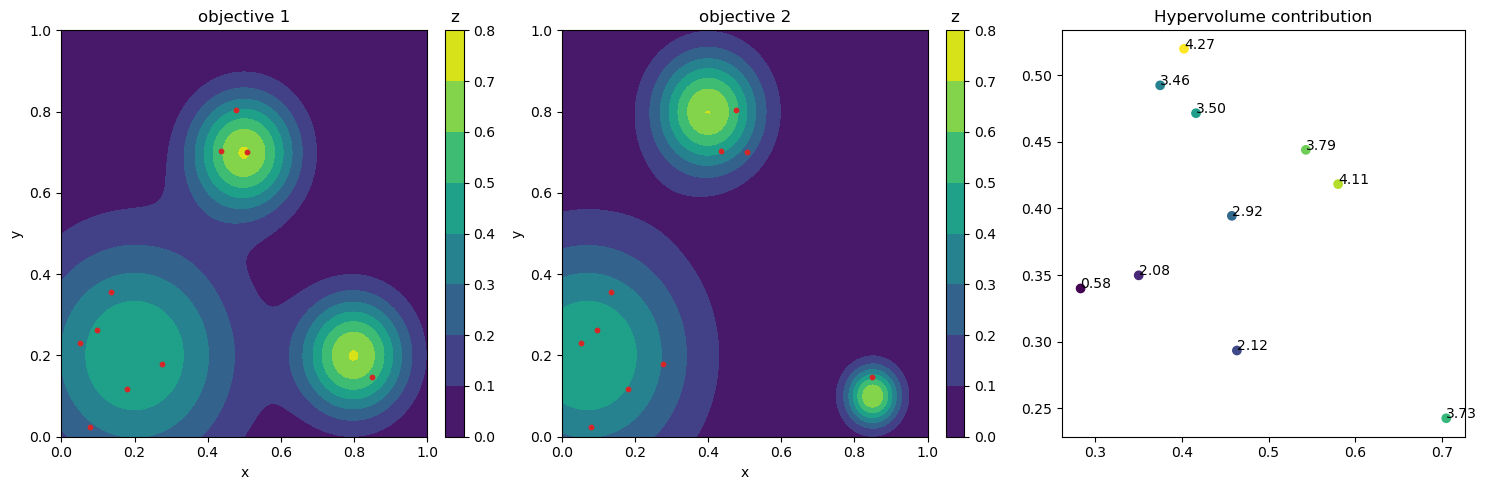

In [33]:
num_dim = problem.bounds.shape[-1]
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.t()[0], 100
    ),
    np.linspace(
        *problem.bounds.t()[1], 100
    ),
)
input_data = np.vstack((xx.flatten(), yy.flatten())).T
input_data = torch.from_numpy(input_data)
z = problem(input_data)

fig = plt.figure(figsize=(5 * (num_dim+1), 5))
for i in range(num_dim):
    ax = plt.subplot2grid((1, num_dim+1), (0, i))
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        z[:, i].reshape(xx.shape),
    )

    # plot observations
    ax.scatter(*init_x[better_than_ref].t(), s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"objective {i+1}")
    clb.ax.set_title('z')

ax = plt.subplot2grid((1, num_dim+1), (0, 2))
ax.scatter(*-y[rank].T, c=range(len(y)))
for obj, h in zip(-y, hvc):
    ax.annotate(f"{h*100:.2f}", (obj[0], obj[1]))
ax.set_title("Hypervolume contribution")
plt.tight_layout()

for gamma in [0.2, 0.4, 0.6, 0.8]:
    print(rf'gamma = {gamma}: {-np.quantile(-100*hvc, q=gamma)}')

In [18]:
mbore = LFBO_JointRand(input_dim=problem.bounds.shape[-1], output_dim=1, weight_type='pi')
mbore.fit(init_x[better_than_ref], torch.tensor(-hvc, **tkwargs).unsqueeze(-1), S=5000)

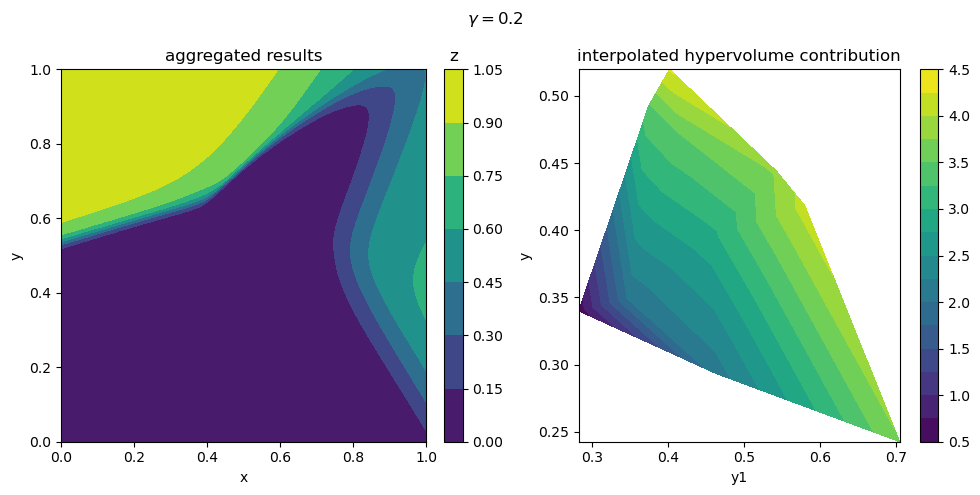

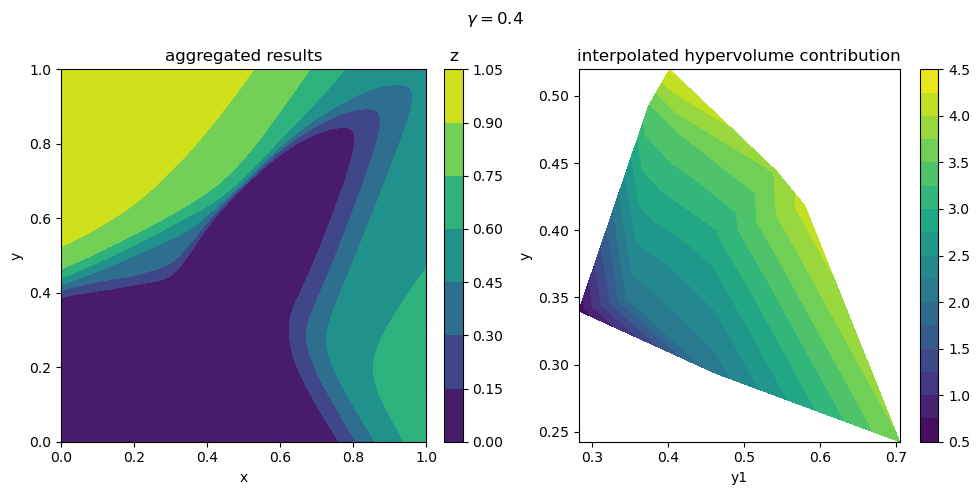

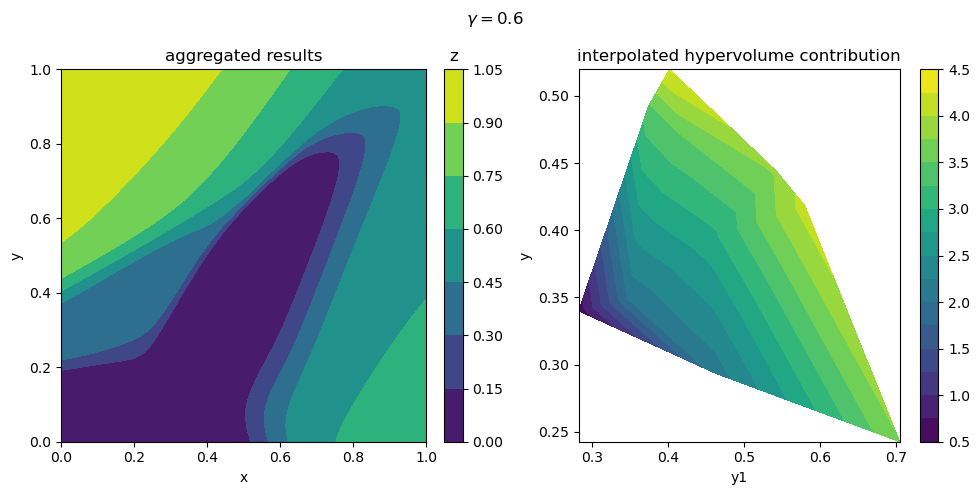

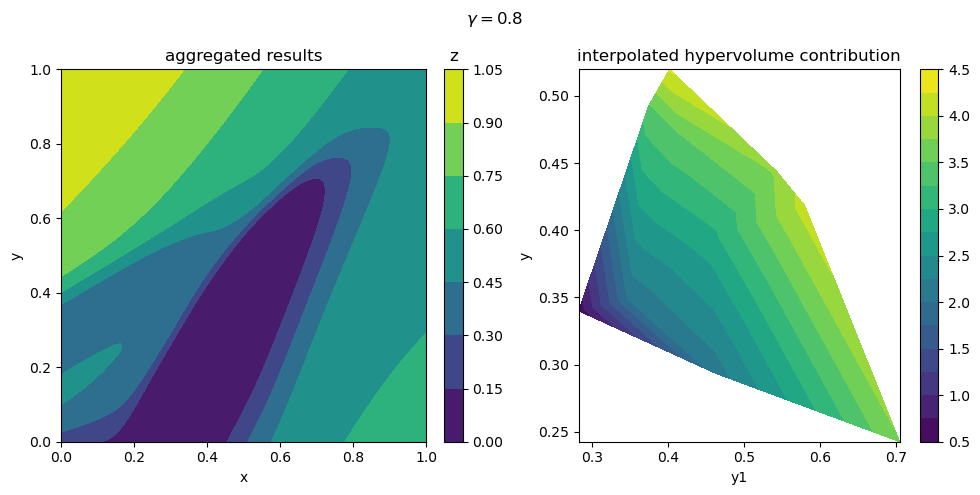

In [38]:
for gamma in [0.2, 0.4, 0.6, 0.8]:
    fig = plt.figure(figsize=(5*2, 5))

    # plot aggregated results
    ax_agg = plt.subplot2grid((1, 2), (0, 0))
    div = make_axes_locatable(ax_agg)
    cax = div.append_axes('right', '5%', '5%')
    preds = mbore.predict(input_data, gamma=gamma)
    countourset = ax_agg.contourf(
        xx,
        yy,
        preds.reshape(xx.shape),
    )
    clb = fig.colorbar(countourset, cax=cax)
    ax_agg.set_xlabel('x')
    ax_agg.set_ylabel('y')
    ax_agg.set_title(f"aggregated results")
    clb.ax.set_title('z')

    ax_pareto = plt.subplot2grid((1, 2), (0, 1))
    # div = make_axes_locatable(ax_pareto)
    # cax = div.append_axes('right', '5%', '5%')
    cntr = ax_pareto.tricontourf(-y[:, 0], -y[:, 1], 100*hvc, levels=14)

    fig.colorbar(cntr, ax=ax_pareto)
    # clb = fig.colorbar(countourset, cax=cax)
    ax_pareto.set_xlabel('y1')
    ax_pareto.set_ylabel('y')
    ax_pareto.set_title(f"interpolated hypervolume contribution")
    
    fig.suptitle(rf"$\gamma={gamma}$")
    plt.tight_layout()
    plt.show()